In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from pprint import pprint
from statsmodels.tsa.stattools import adfuller, pacf, acf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.iolib import SimpleTable
from statsmodels.stats.stattools import durbin_watson
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.stats.diagnostic import het_breuschpagan, het_goldfeldquandt, het_white, het_arch, acorr_ljungbox
from statistics import *
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
from sklearn.pipeline import make_pipeline
from scipy.optimize import curve_fit
from scipy.stats.stats import kurtosis, skew
from scipy.stats import boxcox
from IPython.core.display import display
from patsy import dmatrices
from statsmodels.tsa.statespace.sarimax import SARIMAX
from arch import arch_model
from arch.univariate import ARX, ARCH, GARCH
import warnings
from datetime import datetime, timedelta
import seaborn as sns
warnings.filterwarnings('ignore')

plt.rcParams["figure.figsize"] = (15,8)
plt.rcParams["axes.labelsize"] = 20
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['grid.linewidth'] = .5
plt.rcParams['axes.grid'] = True
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['figure.titlesize'] = 20
plt.rcParams['legend.fontsize'] = 15

In [2]:
df = pd.read_csv('./data/RTSI-dailyhistory-ru.csv', parse_dates=['Date'], index_col='Date', dayfirst=True)
series = df[('2009-01' < df.index) & (df.index < '2020-01')].Close
series = series.resample('14d').last()

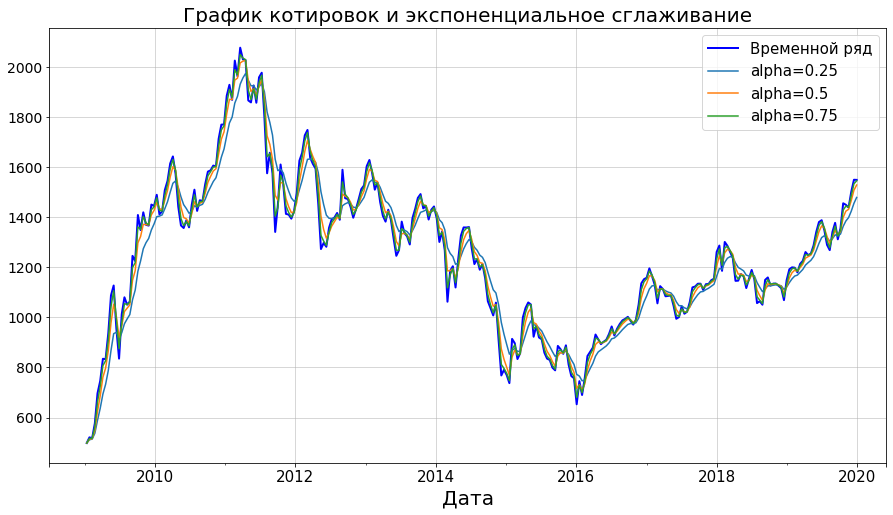

In [3]:
ax = series.plot(legend=True, color='blue', label='Временной ряд', linewidth=2)
for alpha in [.25, .5, .75]:
    series.ewm(alpha=alpha).mean().plot(ax=ax, label=f'alpha={alpha}', legend=True)
ax.set_title('График котировок и экспоненциальное сглаживание')
ax.set_xlabel('Дата');
ax.set_xlim('2008-07', '2020-06')
del ax

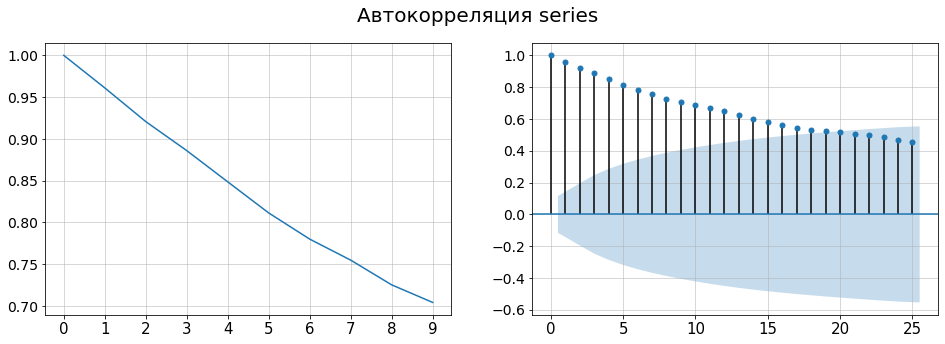

In [4]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))
fig.suptitle('Автокорреляция series')

ax1.set_xticks(np.linspace(0, 10, 11))
ax1.plot(acf(series, fft=False)[:10])

plot_acf(series, ax=ax2, title='');

plt.show();
del fig, ax1, ax2

### Тест Фуллера на стационарность ряда

In [5]:
fuller_test = adfuller(series)
if fuller_test[0] > fuller_test[4]['5%']:
    print('Ряд нестационарен')
else:
    print('Ряд стационарен')
del fuller_test

Ряд нестационарен


# Составление тренда 

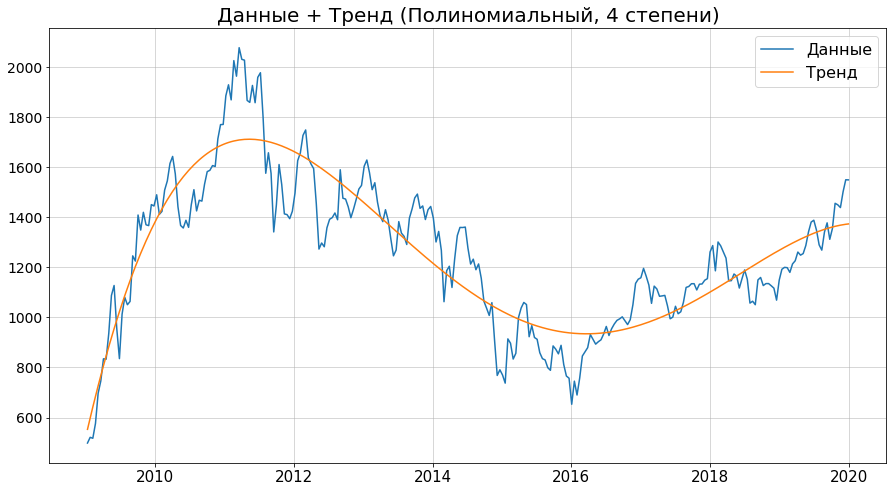

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Close   R-squared:                       0.807
Model:                            OLS   Adj. R-squared:                  0.804
Method:                 Least Squares   F-statistic:                     294.5
Date:                Thu, 26 Mar 2020   Prob (F-statistic):           2.40e-99
Time:                        22:59:18   Log-Likelihood:                -1809.8
No. Observations:                 287   AIC:                             3630.
Df Residuals:                     282   BIC:                             3648.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        552.8941     38.656     14.303      0.000     476.802     628.986
x1            45.7153      1.880     24.319      0.000      42.015      49.416
x2            -0.5766      0.027    -21.517      0.000      -0.629      -0.524
x3             0.0025      0.000     17.606      0.000       0.002       0.003
x4         -3.456e-06   2.44e-07    -14.143      0.000   -3.94e-06   -2.97e-06
==============================================================================
Omnibus:                        0.510   Durbin-Watson:                   0.264
Prob(Omnibus):                  0.775   Jarque-Bera (JB):                0.638
Skew:                          -0.047   Prob(JB):                        0.727
Kurtosis:                       2.789   Cond. No.                     1.10e+10
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.1e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [6]:
pf = PolynomialFeatures(degree=4)
xp = pf.fit_transform(np.arange(series.size)[:, np.newaxis])
fitted_model = sm.OLS(series, xp).fit()

plt.title('Данные + Тренд (Полиномиальный, 4 степени)')
plt.plot(series, label='Данные')

# Значения линии тренда
# Вместо .fittedvalues можно .predict(xp)
series_trend = fitted_model.fittedvalues
series_remains = fitted_model.resid
series_remains_exog = fitted_model.model.exog

plt.plot(series_trend, label='Тренд');
plt.legend(fontsize=16)
plt.show()
display(fitted_model.summary())
del pf, xp, fitted_model

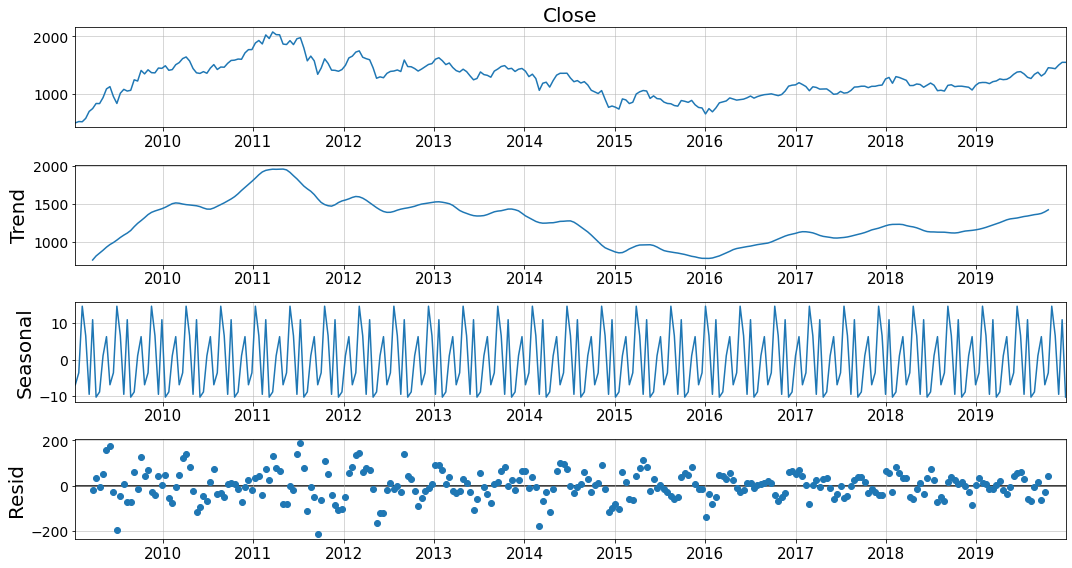

In [7]:
sm.tsa.seasonal_decompose(series.interpolate(), period=10).plot();

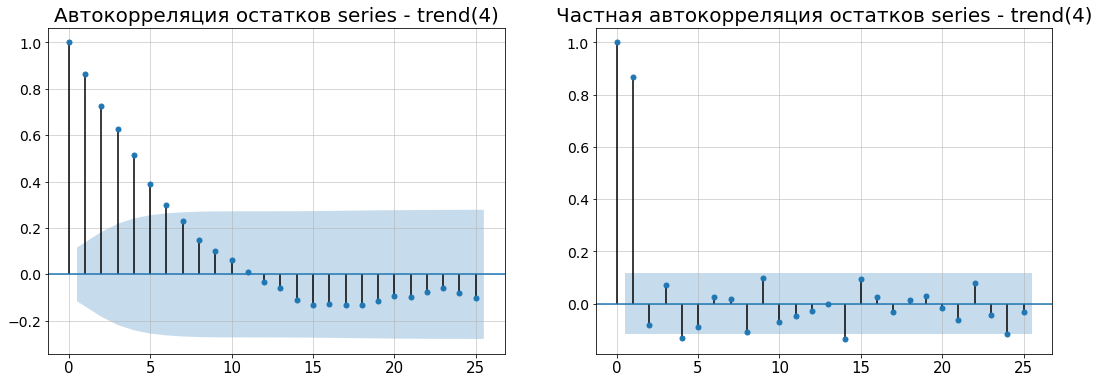

In [8]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
plot_acf(series_remains, title='Автокорреляция остатков series - trend(4)', ax=ax1);
plot_pacf(series_remains, title='Частная автокорреляция остатков series - trend(4)', ax=ax2);

In [9]:
# Лучшие pdq - 4, 0, 4
model = ARIMA(series_remains, order=(4, 0, 4))
arima_by_series_remains = model.fit()
display(arima_by_series_remains.summary())

del model

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                  287
Model:                     ARMA(4, 4)   Log Likelihood               -1595.061
Method:                       css-mle   S.D. of innovations             62.202
Date:                Thu, 26 Mar 2020   AIC                           3210.122
Time:                        22:59:21   BIC                           3246.717
Sample:                    01-11-2009   HQIC                          3224.788
                         - 12-29-2019                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5295      3.252      0.163      0.871      -5.844       6.902
ar.L1.y        1.1493      0.057     20.003      0.000       1.037       1.262
ar.L2.y       -0.4871      0.076     -6.422      0.000      -0.636      -0.338
ar.L3.y        1.1355      0.058     19.609      0.000       1.022       1.249
ar.L4.y       -0.8308      0.041    -20.085      0.000      -0.912      -0.750
ma.L1.y       -0.2357      0.083     -2.829      0.005      -0.399      -0.072
ma.L2.y        0.1375      0.046      2.985      0.003       0.047       0.228
ma.L3.y       -0.9032      0.061    -14.736      0.000      -1.023      -0.783
ma.L4.y        0.0015      0.070      0.021      0.983      -0.136       0.139
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.3788           -0.9559j            1.0282           -0.3100
AR.2           -0.3788           +0.9559j            1.0282            0.3100
AR.3            1.0622           -0.1014j            1.0670           -0.0151
AR.4            1.0622           +0.1014j            1.0670            0.0151
MA.1            1.0001           -0.0000j            1.0001           -0.0000
MA.2           -0.4241           -0.9631j            1.0523           -0.3160
MA.3           -0.4241           +0.9631j            1.0523            0.3160
MA.4          611.2274           -0.0000j          611.2274           -0.0000
-----------------------------------------------------------------------------
"""

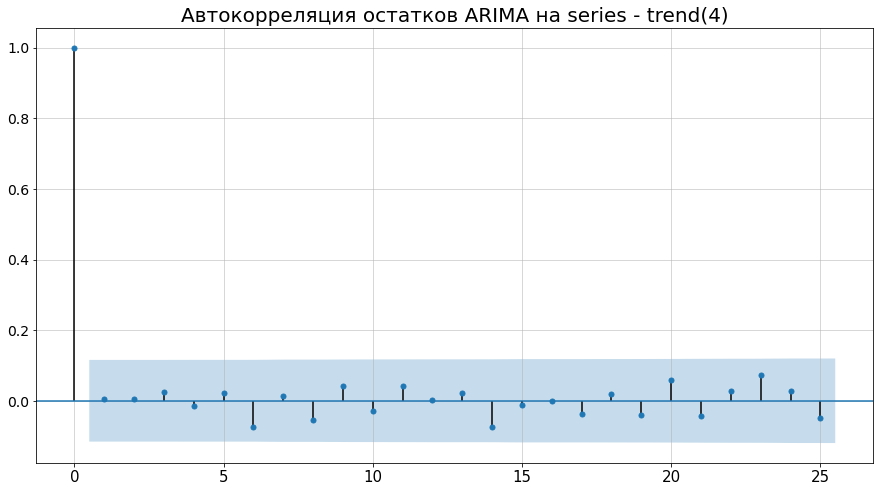

In [10]:
plot_acf(arima_by_series_remains.resid, title='Автокорреляция остатков ARIMA на series - trend(4)');

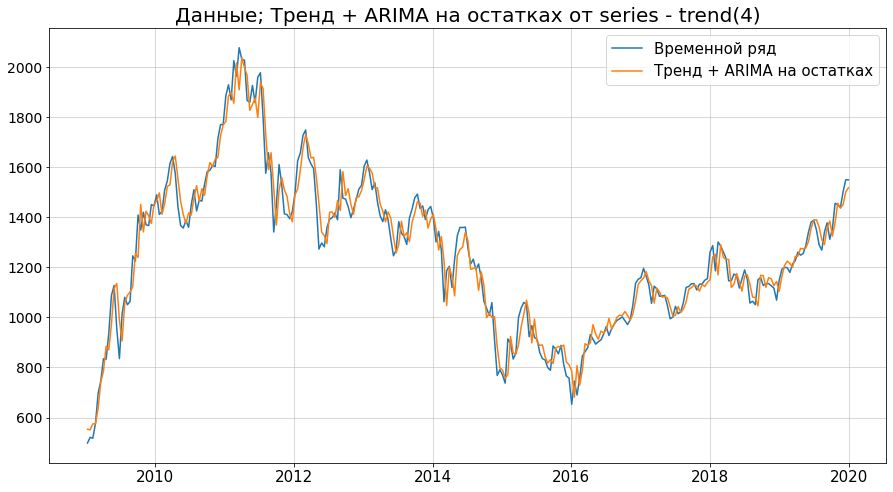

In [11]:
plt.plot(series, label='Временной ряд');
plt.plot(series_trend + arima_by_series_remains.fittedvalues, label='Тренд + ARIMA на остатках');
plt.title('Данные; Тренд + ARIMA на остатках от series - trend(4)')
plt.legend()
plt.show()

# Проверка предпосылок регрессионного анализа (остатков от тренда)
#### - Нулевая средняя величина
#### - Остатки подчиняются нормальному распределению
#### - Случайный характер остатков
#### - Гомоскедастичность
#### - Отсутствие автокорреляции
#### (Некоторые тесты выводятся выше при составлении тренда (Дарбин-Уотсон)

## 1)Нулевая средняя величина

In [12]:
print('Средняя величина остатков:', series_remains.mean())

Средняя величина остатков: -1.3813313189086506e-05


## 2)Остатки подчиняются нормальному распределению 

### На уровне значимости 0.05, нулевая гипотеза о нормальности распределения принимается

In [13]:
display(SimpleTable(
    np.array([sm.stats.stattools.jarque_bera(series_remains)]),
     ['JB', 'p-value', 'skew', 'kurtosis']
))
# Гипотеза Н0 - о нормальном распределении остатков
# Чем ближе распределение ошибок к нормальному, тем меньше статистика Харке—Бера отличается от нуля.
#При достаточно большом значении статистики p-value будет мало,
#и тогда будет основание отвергнуть нулевую гипотезу (статистика попала в «хвост» распределения). 

JB,p-value,skew,kurtosis
0.63823696479121,0.7267894324517161,-0.04722375151813403,2.7891649900572424


### Критерии ассиметрии и эксцесса, и РС

In [14]:
kurt = kurtosis(series_remains)
n = series_remains.size
kurt_critical = 5*(24*n*(n-2)*(n-3)/(n+1)**2/(n+3)/(n+4))**.5
sk = skew(series_remains)
sk_critical = 3*(6*(n-1)/(n+1)/(n+3))**.5

if kurt < kurt_critical:
    print(f'Эксцесс {kurt:.4f} меньше критического {kurt_critical:.4f}')
else:
    print(f'Эксцесс {kurt:.4f} больше, либо равен критическому {kurt_critical:.4f}')

if sk < sk_critical:
    print(f'Ассиметрия {sk:.4f} меньше критического {sk_critical:.4f}')
else:
    print(f'Ассиметрия {sk:.4f} больше, либо равна критической {sk_critical:.4f}')
    
rem = series_remains
# Полученное значение сравнивается с табличными 
# С вероятностью ошибки-0.05 и длиной выборки-100 РС критерий должен быть в диапазон(4.31; 5.9)
rc = (rem.max() - rem.min()) / ((rem**2).sum()/len(rem)-1)**.5
print(f'РС критерий: {rc:.4f}')

Эксцесс -0.2108 меньше критического 1.4111
Ассиметрия -0.0472 меньше критического 0.4300
РС критерий: 5.4547


## 3)Случайный характер остатков 

In [15]:
fuller_test = adfuller(series_remains)
if fuller_test[0] > fuller_test[4]['5%']:
    print('Ряд нестационарен')
else:
    print('Ряд стационарен')
del fuller_test
#H0 - наличие единичного корня т.е. нестационарность ряда
# Если p-value (второе значение теста) больше критического (0.05), то мы не можем отвергнуть нулевую гипотезу
# + проверяем значение самого теста. Если значение > критического от 5%, то ряд нестационарен.

Ряд стационарен


## 4)Гомоскедастичность

In [16]:
bp_test = het_breuschpagan(series_remains, series_remains_exog)
labels = ["LM Statistic", "LM-Test p-value", "F-Statistic", "F-Test p-value"]
print(dict(zip(labels, bp_test)))
# H0 - наличие гомоскедастичности. Если оба p-value меньше 0.05 - гетероскедастичность

{'LM Statistic': 38.48711407810963, 'LM-Test p-value': 8.8902953963719e-08, 'F-Statistic': 10.918313279575985, 'F-Test p-value': 3.033077512239444e-08}


In [17]:
het_goldfeldquandt(series_remains, series_remains_exog, store=True)
# H0 - о равенстве дисперсий в двух подвыборках (гомоскедастичность)
# Смотрим на второе число (p-value) - p-value гипотезы что дисперсии отличаются. Если большое, то гетероскедастичность

(0.2832167210933001,
 0.9999999999996494,
 'increasing',
 <statsmodels.stats.diagnostic.ResultsStore at 0x7f9624ac0a10>)

### Тест Уайта

### F-критическое ищется по таблице F(0.01; 13, 120) = 3.255

### 5.94 > F критическое => уравнение значимое => гетероскедастичность

### Если последнее число(значимость F) < 0.05 => гетероскедастичность

In [18]:
#1 вариант - использует дисперсии
white_test = het_white(series_remains, series_remains_exog)
labels = ["LM Statistic", "LM-Test p-value", "F-Statistic", "F-Test p-value"]
print(dict(zip(labels, white_test)))
# Тест аналогичен с бройшем паганом

{'LM Statistic': 36.1548619859563, 'LM-Test p-value': 2.689003478692651e-07, 'F-Statistic': 10.161320208116678, 'F-Test p-value': 1.0669524938061977e-07}


### Тест Уайта вручную (другой вариант теста)

### При гетероскедастичности все полученные члены будут значимы и p-value>0.05

In [19]:
tmp = series_remains.to_frame()
tmp['t'] = np.arange(tmp.size)
tmp['t2'] = tmp.t ** 2
tmp['t3'] = tmp.t ** 3
tmp['t4'] = tmp.t2 ** 2
tmp['t22'] = tmp.t2.copy()
tmp['t44'] = tmp.t4.copy()
tmp['t6'] = tmp.t3 ** 2
tmp['t8'] = tmp.t4 ** 2

tmp['a'] = tmp.t3.copy()
tmp['b'] = tmp.t4.copy()
tmp['c'] = tmp.t4 * tmp.t
tmp['d'] = tmp.t4 * tmp.t
tmp['e'] = tmp.t3 ** 2
tmp['f'] = tmp.t3 * tmp.t4
tmp['remains'] = series_remains ** 2

In [20]:
f = smf.ols('remains ~ (t + t2 + t3 + t4 + t22 + t44 + t6 + t8 + a + b + c + d + e + f)', data=tmp).fit()
display(f.summary())
del tmp

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                remains   R-squared:                       0.043
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     2.554
Date:                Thu, 26 Mar 2020   Prob (F-statistic):             0.0279
Time:                        22:59:22   Log-Likelihood:                -3289.5
No. Observations:                 287   AIC:                             6591.
Df Residuals:                     281   BIC:                             6613.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   2.583e-06    3.2e-07      8.079      0.000    1.95e-06    3.21e-06
t              0.0001   1.74e-05      8.079      0.000       0.000       0.000
t2             0.0067      0.001      8.079      0.000       0.005       0.008
t3             0.2085      0.026      8.079      0.000       0.158       0.259
t4            -0.0026      0.000     -7.168      0.000      -0.003      -0.002
t22            0.0067      0.001      8.079      0.000       0.005       0.008
t44           -0.0026      0.000     -7.168      0.000      -0.003      -0.002
t6         -1.336e-07      2e-08     -6.694      0.000   -1.73e-07   -9.43e-08
t8         -4.161e-16   5.06e-16     -0.823      0.411   -1.41e-15    5.79e-16
a              0.2085      0.026      8.079      0.000       0.158       0.259
b             -0.0026      0.000     -7.168      0.000      -0.003      -0.002
c           2.769e-05   4.25e-06      6.514      0.000    1.93e-05    3.61e-05
d           2.769e-05   4.25e-06      6.514      0.000    1.93e-05    3.61e-05
e          -3.802e-08    8.8e-09     -4.320      0.000   -5.53e-08   -2.07e-08
f            1.97e-10   3.49e-11      5.642      0.000    1.28e-10    2.66e-10
==============================================================================
Omnibus:                       96.656   Durbin-Watson:                   0.680
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              267.324
Skew:                           1.543   Prob(JB):                     8.94e-59
Kurtosis:                       6.582   Cond. No.                     2.16e+32
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 5.76e-26. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

### Тест парка на гомоскедастичность

### Гетероскедастичность если полученные уравнение по F-критерию значимы и значимый КФ при ln фактора

In [21]:
tmp = series.to_frame()
tmp['t'] = np.log(np.arange(1, series.size+1))
tmp['t2'] = np.log(np.arange(1, series.size+1)**2)
tmp['t3'] = np.log(np.arange(1, series.size+1)**3)
tmp['t4'] = np.log(np.arange(1, series.size+1)**4)
tmp['Close2'] = np.log(series_remains ** 2)
tmp

,Close,t,t2,t3,t4,Close2
Date,,,,,,
2009-01-11,498.20,0.000000,0.000000,0.000000,0.000000,8.003513
2009-01-25,520.91,0.693147,1.386294,2.079442,2.772589,8.690864
2009-02-08,517.22,1.098612,2.197225,3.295837,4.394449,9.653718
2009-02-22,576.39,1.386294,2.772589,4.158883,5.545177,9.374010
2009-03-08,696.93,1.609438,3.218876,4.828314,6.437752,6.786210
...,...,...,...,...,...,...
2019-11-03,1449.42,5.645447,11.290894,16.936341,22.581788,8.849360
2019-11-17,1438.45,5.648974,11.297948,16.946923,22.595897,8.506588
2019-12-01,1501.42,5.652489,11.304978,16.957468,22.609957,9.756340


In [22]:
smf.ols('Close2 ~ t', data=tmp).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Close2   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     2.173
Date:                Thu, 26 Mar 2020   Prob (F-statistic):              0.142
Time:                        22:59:22   Log-Likelihood:                -640.91
No. Observations:                 287   AIC:                             1286.
Df Residuals:                     285   BIC:                             1293.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      9.4559      0.663     14.271      0.000       8.152      10.760
t             -0.2047      0.139     -1.474      0.142      -0.478       0.069
==============================================================================
Omnibus:                      111.303   Durbin-Watson:                   0.945
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              417.447
Skew:                          -1.646   Prob(JB):                     2.25e-91
Kurtosis:                       7.906   Cond. No.                         24.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [23]:
smf.ols('Close2 ~ t2', data=tmp).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Close2   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     2.173
Date:                Thu, 26 Mar 2020   Prob (F-statistic):              0.142
Time:                        22:59:22   Log-Likelihood:                -640.91
No. Observations:                 287   AIC:                             1286.
Df Residuals:                     285   BIC:                             1293.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      9.4559      0.663     14.271      0.000       8.152      10.760
t2            -0.1024      0.069     -1.474      0.142      -0.239       0.034
==============================================================================
Omnibus:                      111.303   Durbin-Watson:                   0.945
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              417.447
Skew:                          -1.646   Prob(JB):                     2.25e-91
Kurtosis:                       7.906   Cond. No.                         47.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [24]:
smf.ols('Close2 ~ t3', data=tmp).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Close2   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     2.173
Date:                Thu, 26 Mar 2020   Prob (F-statistic):              0.142
Time:                        22:59:22   Log-Likelihood:                -640.91
No. Observations:                 287   AIC:                             1286.
Df Residuals:                     285   BIC:                             1293.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      9.4559      0.663     14.271      0.000       8.152      10.760
t3            -0.0682      0.046     -1.474      0.142      -0.159       0.023
==============================================================================
Omnibus:                      111.303   Durbin-Watson:                   0.945
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              417.447
Skew:                          -1.646   Prob(JB):                     2.25e-91
Kurtosis:                       7.906   Cond. No.                         71.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## 5)Проверка автокорр.

### Сравниваем эту T-статистику КФ автокорр. с T-табличным 
### (если |Tрасч|>Tтабл, то отклоняем H0 о незначимости коэф)

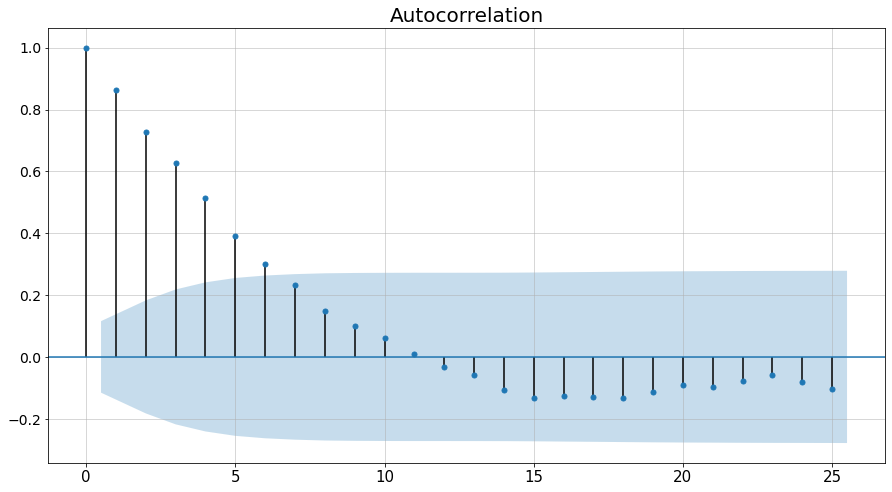

In [25]:
plot_acf(series_remains);

In [26]:
_kf = acf(series_remains, fft=False)[1]
t = (((_kf**2) * (series.size-2)) / (1-_kf**2))**.5

In [27]:
#Смотрим на зону, в которую попадает это число. (Если меньше примерно 1.5, то положительная автокорреляция)
durbin_watson(series_remains)

0.26390665109905476

# Проверка остатков после (trend + Arima) 

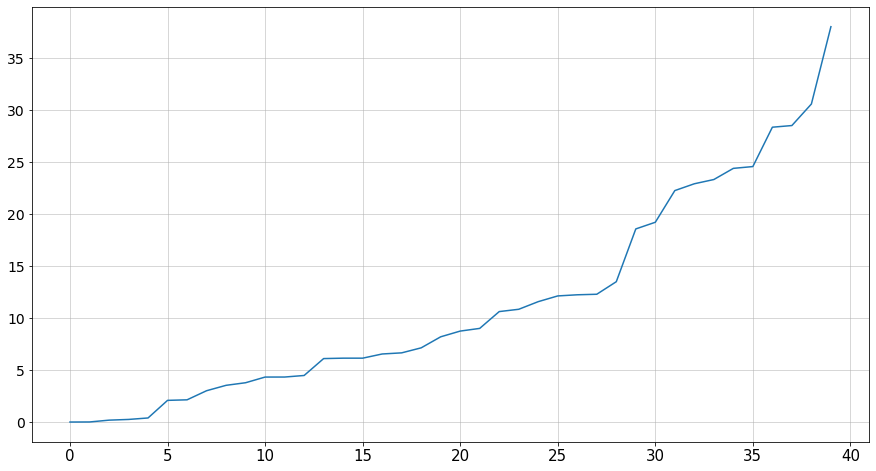

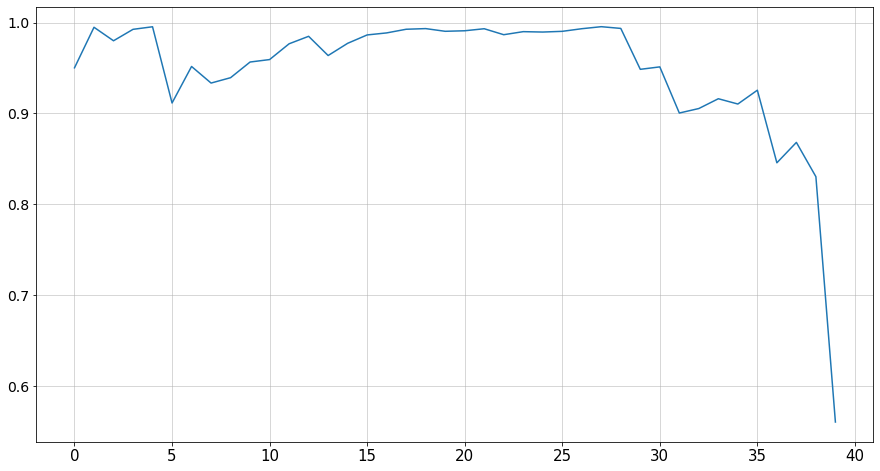

In [28]:
q_test = acf(arima_by_series_remains.resid, qstat=True, fft=False)
q_df = pd.DataFrame({'Q-stat': q_test[1], 'p-value': q_test[2]})
q_df['Q-stat'].plot()
plt.show()
q_df['p-value'].plot();
del q_test, q_df

In [29]:
acorr_ljungbox(arima_by_series_remains.resid, return_df=True)
# H0 - данные являются "белым шумом"
# Также можно сверить Q статистику с таблицей распределения ХИ-КВАДРАТ

,lb_stat,lb_pvalue
1,0.003890,0.950269
2,0.010189,0.994918
3,0.184488,0.980054
4,0.253001,0.992643
5,0.394696,0.995474
6,2.087037,0.911522
7,2.139030,0.951746
8,3.013838,0.933486
9,3.532801,0.939393
10,3.781834,0.956653


### Остатки полученные после тренд + ARIMA по критерию бокса-льюинга являются белым шумом (поскольку все p-value до 40 лага >0.05)

# ARIMA на исходные данные 

In [30]:
arima_by_series = ARIMA(series, order=(3, 1, 3)).fit()

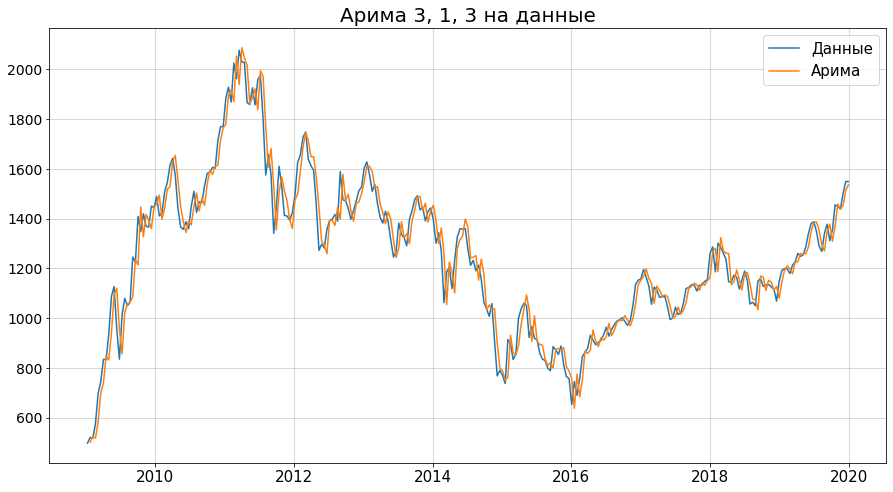

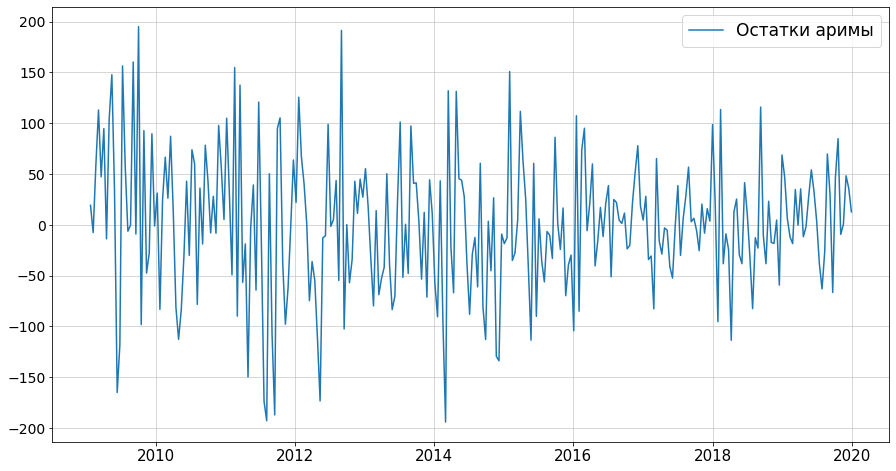

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.Close   No. Observations:                  286
Model:                 ARIMA(3, 1, 3)   Log Likelihood               -1609.013
Method:                       css-mle   S.D. of innovations             67.079
Date:                Thu, 26 Mar 2020   AIC                           3234.026
Time:                        22:59:24   BIC                           3263.274
Sample:                    01-25-2009   HQIC                          3245.749
                         - 12-29-2019                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             3.5118      3.911      0.898      0.369      -4.154      11.178
ar.L1.D.Close     0.2799      0.047      6.013      0.000       0.189       0.371
ar.L2.D.Close    -0.2262      0.040     -5.634      0.000      -0.305      -0.148
ar.L3.D.Close     0.9456      0.037     25.437      0.000       0.873       1.018
ma.L1.D.Close    -0.2283      0.058     -3.956      0.000      -0.341      -0.115
ma.L2.D.Close     0.1352      0.044      3.054      0.002       0.048       0.222
ma.L3.D.Close    -0.9069      0.059    -15.375      0.000      -1.023      -0.791
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0003           -0.0000j            1.0003           -0.0000
AR.2           -0.3805           -0.9552j            1.0282           -0.3103
AR.3           -0.3805           +0.9552j            1.0282            0.3103
MA.1            1.0000           -0.0000j            1.0000           -0.0000
MA.2           -0.4255           -0.9600j            1.0501           -0.3164
MA.3           -0.4255           +0.9600j            1.0501            0.3164
-----------------------------------------------------------------------------
"""

In [31]:
plt.plot(series, label='Данные')
plt.plot(series - arima_by_series.resid, label='Арима')
plt.title(f'Арима {arima_by_series.k_ar}, {arima_by_series.k_diff}, {arima_by_series.k_ma} на данные')
plt.legend(fontsize=15)
plt.show()

plt.plot(arima_by_series.resid, label='Остатки аримы')
plt.legend(fontsize=17)
plt.show();
arima_by_series.summary()

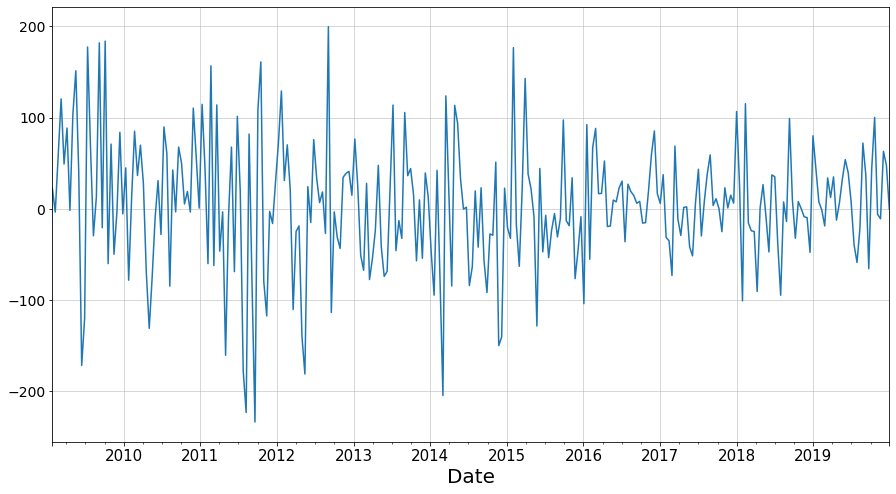

In [32]:
(arima_by_series.fittedvalues + arima_by_series.resid).plot()

### Проверим остатки от этой ARIMA на белый шум

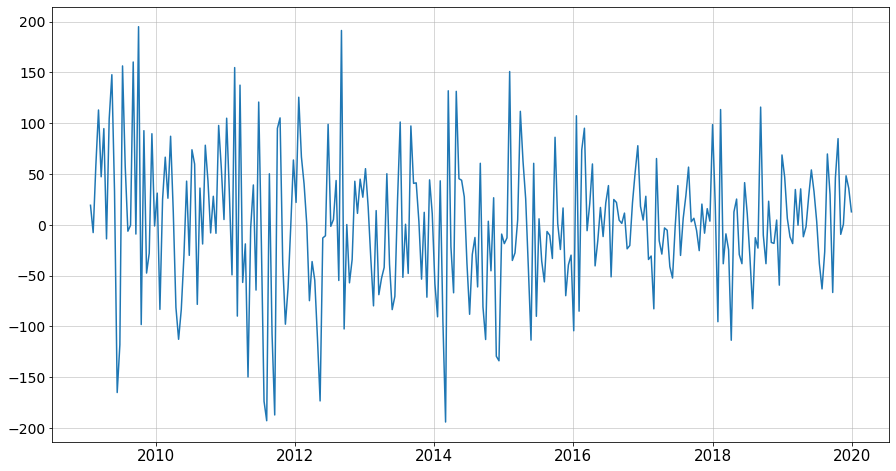

In [33]:
plt.plot(arima_by_series.resid, label='Остатки аримы')

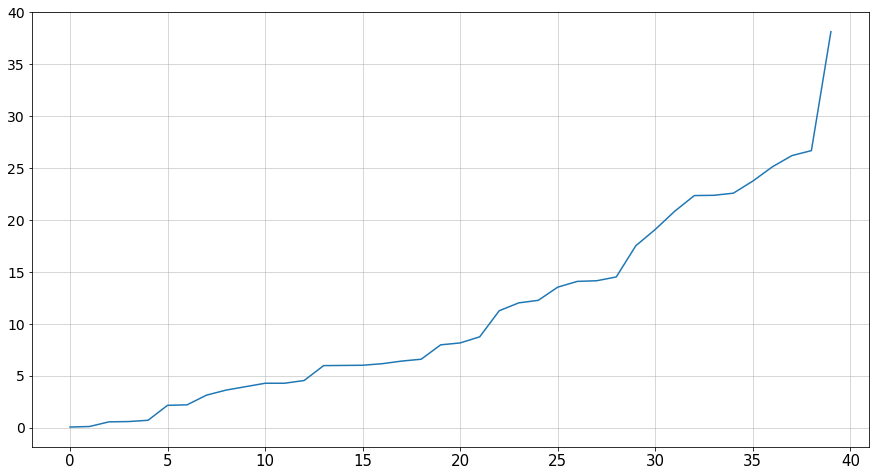

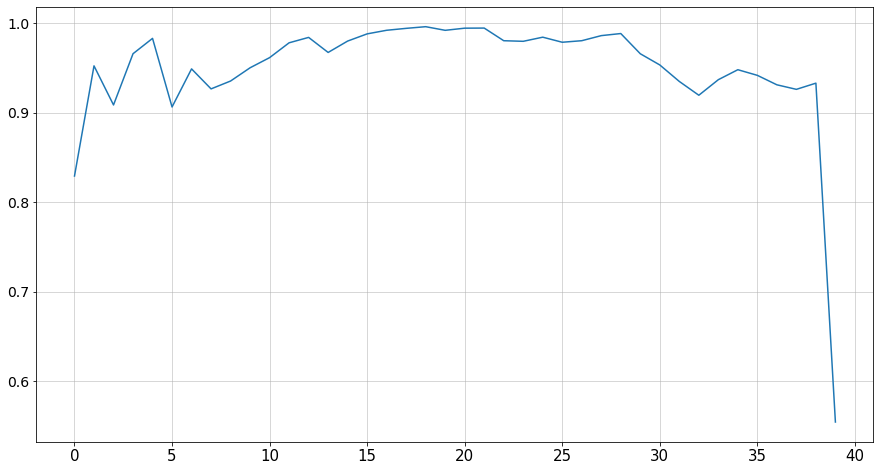

In [34]:
q_test = acf(arima_by_series.resid, qstat=True, fft=False)
q_df = pd.DataFrame({'Q-stat': q_test[1], 'p-value': q_test[2]})
q_df['Q-stat'].plot()
plt.show()
q_df['p-value'].plot();
del q_test, q_df

In [35]:
acorr_ljungbox(arima_by_series.resid, return_df=True)
# H0 - данные являются "белым шумом"
# Также можно сверить Q статистику с таблицей распределения ХИ-КВАДРАТ

,lb_stat,lb_pvalue
1,0.046567,0.829149
2,0.097672,0.952337
3,0.546211,0.908628
4,0.573989,0.965910
5,0.698109,0.983072
6,2.140303,0.906353
7,2.184122,0.948951
8,3.120157,0.926592
9,3.605947,0.935385
10,3.935742,0.950199


### Пробуем предиктить

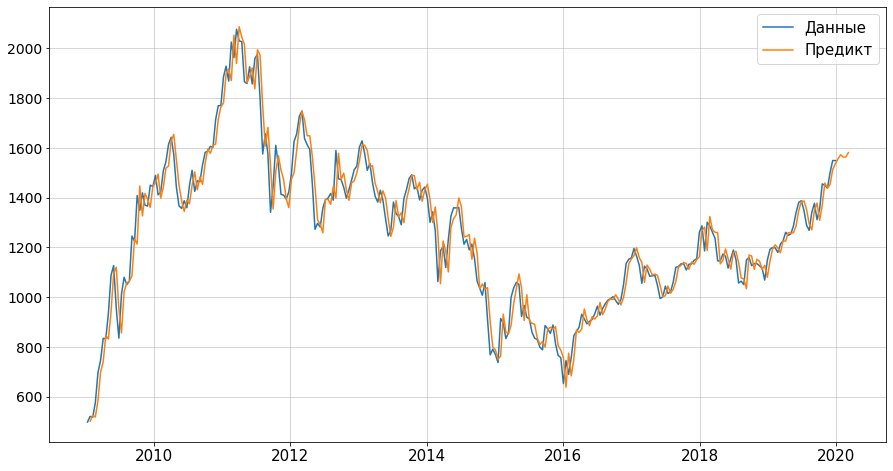

In [36]:
start = series[-1]
predicted = arima_by_series.predict('2020', '2020-03')
for i in range(len(predicted)):
    predicted[i] += start
    start = predicted[i]

plt.plot(series, label='Данные')
plt.plot((series - arima_by_series.resid).append(predicted), label='Предикт')
plt.legend()
plt.show();

In [37]:
series2020 = df[df.index >= '2019-12-31'].Close
predicted2020 = (series - arima_by_series.resid).append(predicted)
predicted2020 = predicted2020[predicted2020.index >= '2019-12']

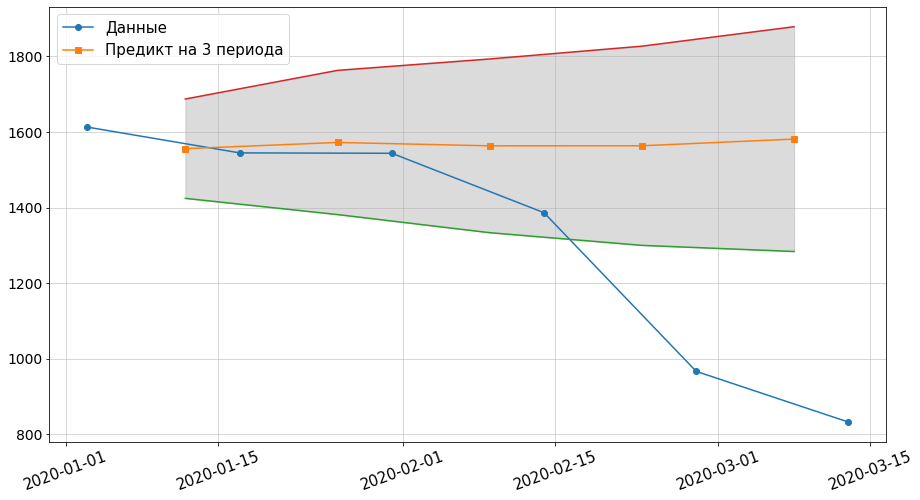

In [38]:
plt.plot(series2020.resample('14d').last(), label='Данные', marker='o')
plt.plot(predicted, label='Предикт на 3 периода', marker='s')
plt.plot(pd.Series(map(lambda x: x[0], arima_by_series.forecast(5)[2]), index=predicted.index))
plt.plot(pd.Series(map(lambda x: x[1], arima_by_series.forecast(5)[2]), index=predicted.index))
plt.fill_between(
    predicted.index, 
    pd.Series(map(lambda x: x[0], arima_by_series.forecast(5)[2]), index=predicted.index),
    pd.Series(map(lambda x: x[1], arima_by_series.forecast(5)[2]), index=predicted.index),
    color=((.3, .3, .3, .2), )
)
plt.xticks(rotation=20)
plt.legend();

## Тест CHOW

In [39]:
# Оптимальный '2011-10-31' / '2016-03-31'
#chow_test_result, split_point1, partial_series = \
#     Model(series['2011-06': ] ).cut_by_chow_test(arbitrarily=2, with_result=True)
#draw(partial_series)

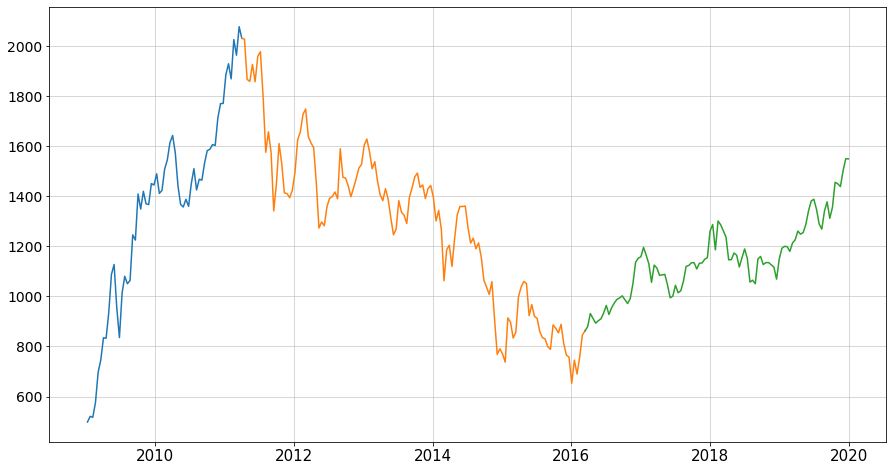

In [40]:
partial_series = PartialModel(series[:'2011-03'], series['2011-04':'2016-02'], series['2016-03':])
draw(partial_series)

### 1-ый кусок

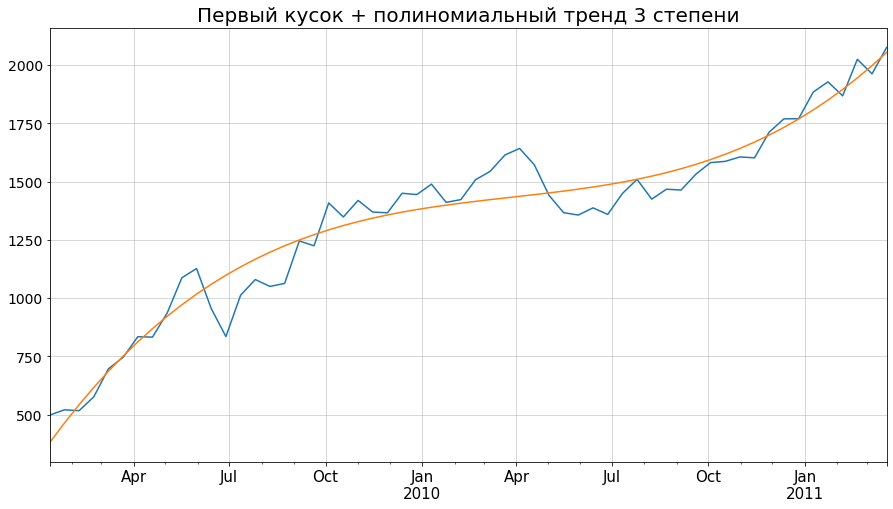

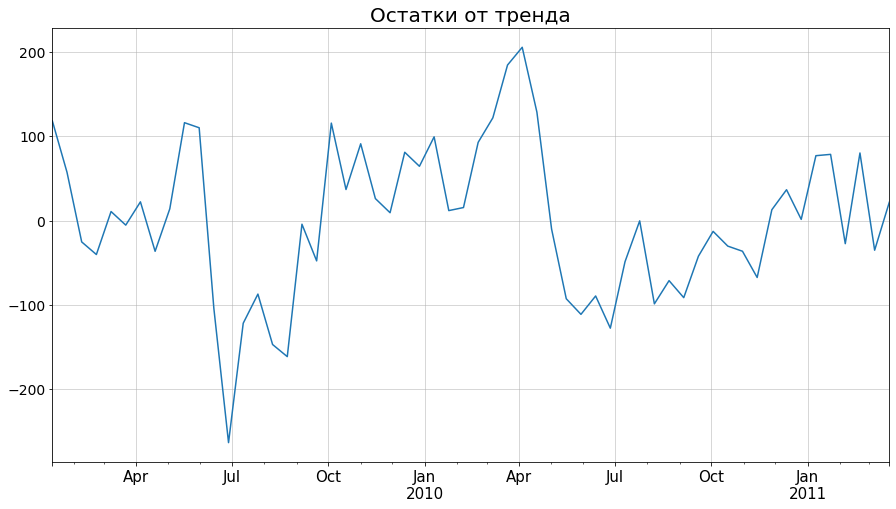

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Close   R-squared:                       0.946
Model:                            OLS   Adj. R-squared:                  0.943
Method:                 Least Squares   F-statistic:                     314.1
Date:                Thu, 26 Mar 2020   Prob (F-statistic):           3.82e-34
Time:                        22:59:27   Log-Likelihood:                -342.83
No. Observations:                  58   AIC:                             693.7
Df Residuals:                      54   BIC:                             701.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        380.0509     45.625      8.330      0.000     288.578     471.524
x1            86.1738      6.993     12.323      0.000      72.154     100.193
x2            -2.5108      0.286     -8.764      0.000      -3.085      -1.936
x3             0.0266      0.003      8.046      0.000       0.020       0.033
==============================================================================
Omnibus:                        0.804   Durbin-Watson:                   0.715
Prob(Omnibus):                  0.669   Jarque-Bera (JB):                0.357
Skew:                          -0.173   Prob(JB):                        0.837
Kurtosis:                       3.169   Cond. No.                     2.71e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.71e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [41]:
partial_series.p1.plot()
partial_series.p1.polynomial_trend(3).plot()
plt.title('Первый кусок + полиномиальный тренд 3 степени')
plt.xlabel('')
plt.show()

partial_series.p1.polynomial_trend(3).fitted_model.resid.plot();
plt.title('Остатки от тренда')
plt.xlabel('')
plt.show()
display(partial_series.p1.polynomial_trend(3).fitted_model.summary())

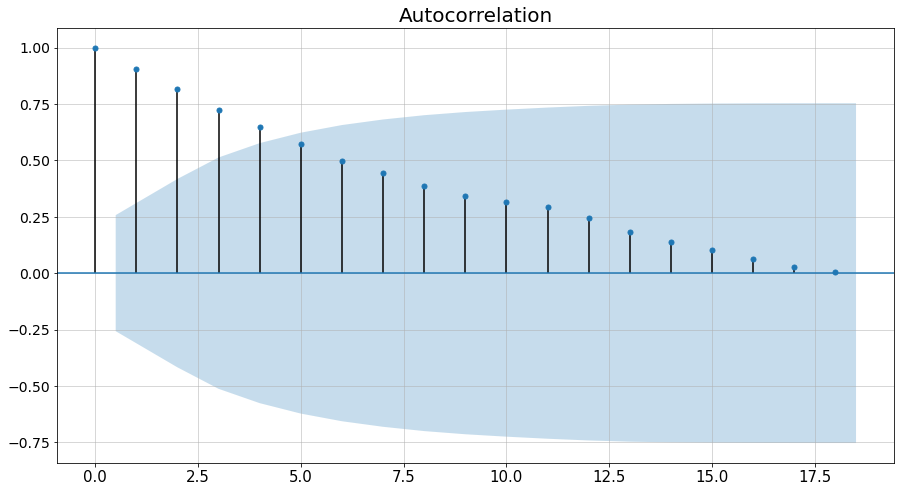

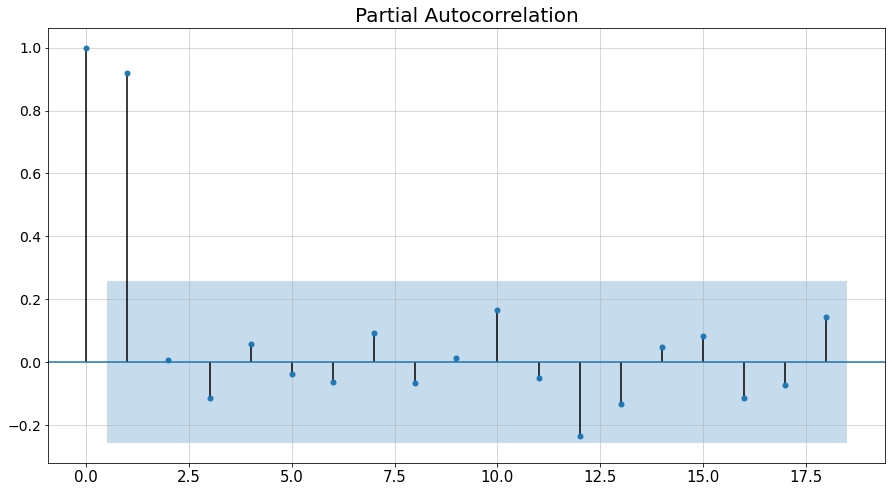

In [42]:
plot_acf(partial_series.p1)
plot_pacf(partial_series.p1);

### 2-ой кусок 

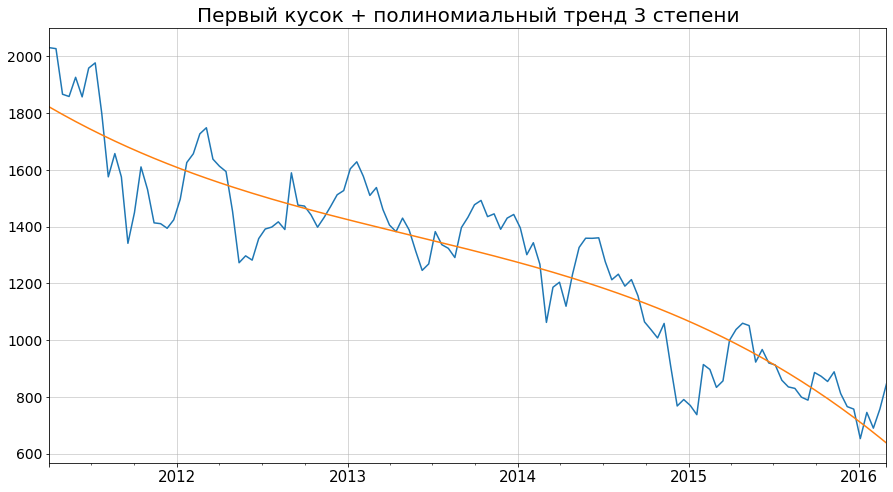

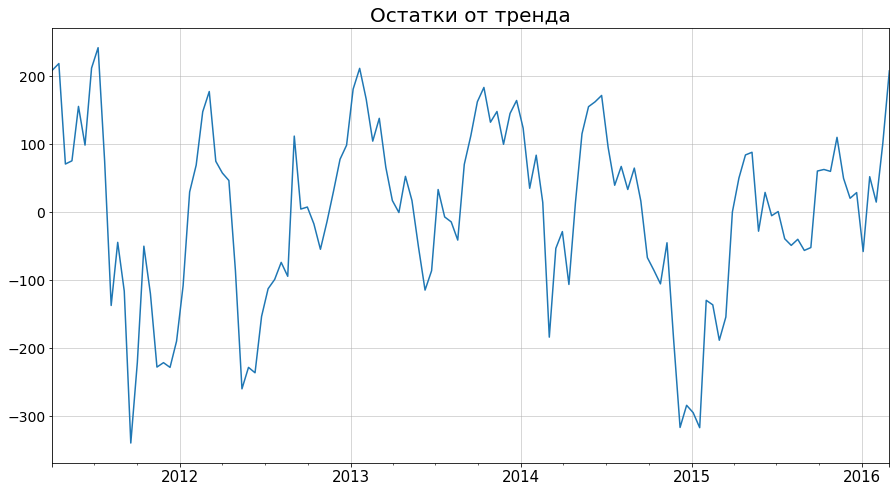

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Close   R-squared:                       0.840
Model:                            OLS   Adj. R-squared:                  0.836
Method:                 Least Squares   F-statistic:                     218.6
Date:                Thu, 26 Mar 2020   Prob (F-statistic):           1.55e-49
Time:                        22:59:28   Log-Likelihood:                -810.83
No. Observations:                 129   AIC:                             1630.
Df Residuals:                     125   BIC:                             1641.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1821.1924     45.147     40.339      0.000    1731.840    1910.545
x1           -13.3032      3.067     -4.338      0.000     -19.372      -7.234
x2             0.1394      0.056      2.498      0.014       0.029       0.250
x3            -0.0008      0.000     -2.937      0.004      -0.001      -0.000
==============================================================================
Omnibus:                        6.014   Durbin-Watson:                   0.369
Prob(Omnibus):                  0.049   Jarque-Bera (JB):                6.203
Skew:                          -0.526   Prob(JB):                       0.0450
Kurtosis:                       2.778   Cond. No.                     3.12e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.12e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [43]:
partial_series.p2.plot()
partial_series.p2.polynomial_trend(3).plot()
plt.title('Первый кусок + полиномиальный тренд 3 степени')
plt.xlabel('')
plt.show()

partial_series.p2.polynomial_trend(3).fitted_model.resid.plot();
plt.title('Остатки от тренда')
plt.xlabel('')
plt.show()
display(partial_series.p2.polynomial_trend(3).fitted_model.summary())

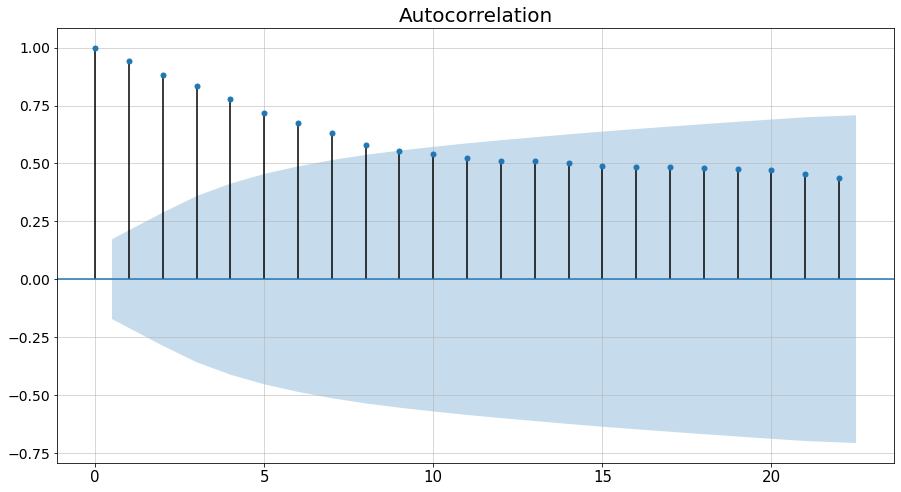

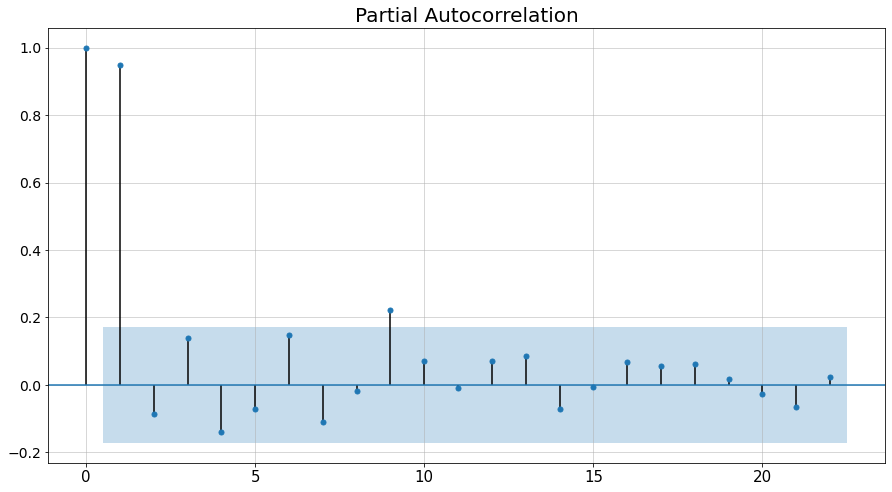

In [44]:
plot_acf(partial_series.p2)
plot_pacf(partial_series.p2);

### 3-ий кусок

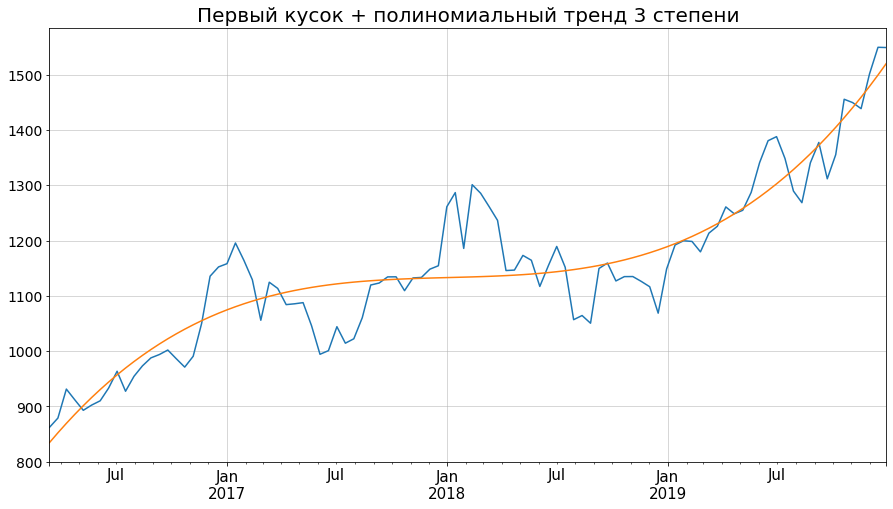

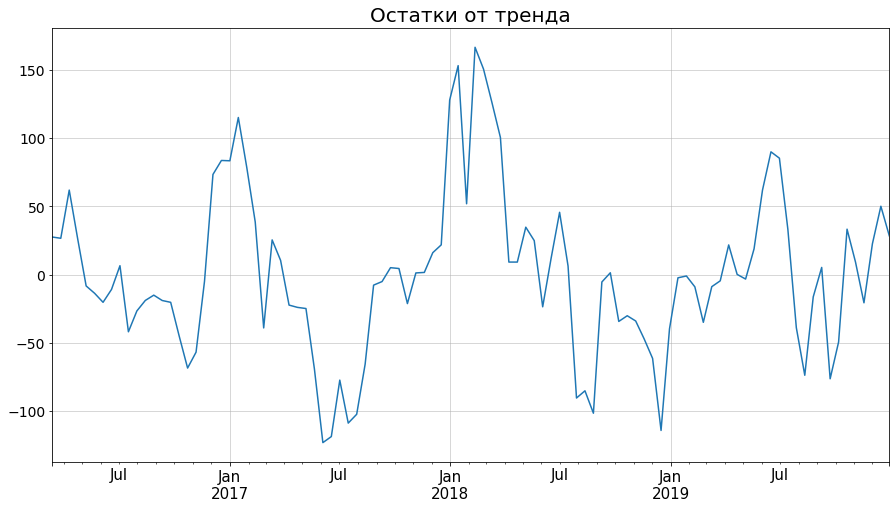

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Close   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     172.4
Date:                Thu, 26 Mar 2020   Prob (F-statistic):           1.59e-38
Time:                        22:59:29   Log-Likelihood:                -549.97
No. Observations:                 100   AIC:                             1108.
Df Residuals:                      96   BIC:                             1118.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        834.6645     23.287     35.843      0.000     788.441     880.888
x1            18.1505      2.047      8.866      0.000      14.087      22.214
x2            -0.3756      0.048     -7.794      0.000      -0.471      -0.280
x3             0.0026      0.000      8.281      0.000       0.002       0.003
==============================================================================
Omnibus:                        5.190   Durbin-Watson:                   0.476
Prob(Omnibus):                  0.075   Jarque-Bera (JB):                4.522
Skew:                           0.460   Prob(JB):                        0.104
Kurtosis:                       3.490   Cond. No.                     1.44e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.44e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [45]:
partial_series.p3.plot()
partial_series.p3.polynomial_trend(3).plot()
plt.title('Первый кусок + полиномиальный тренд 3 степени')
plt.xlabel('')
plt.show()

partial_series.p3.polynomial_trend(3).fitted_model.resid.plot();
plt.title('Остатки от тренда')
plt.xlabel('')
plt.show()
display(partial_series.p3.polynomial_trend(3).fitted_model.summary())

### Выведем склеенный тренд и применим на все остатки ARIMA

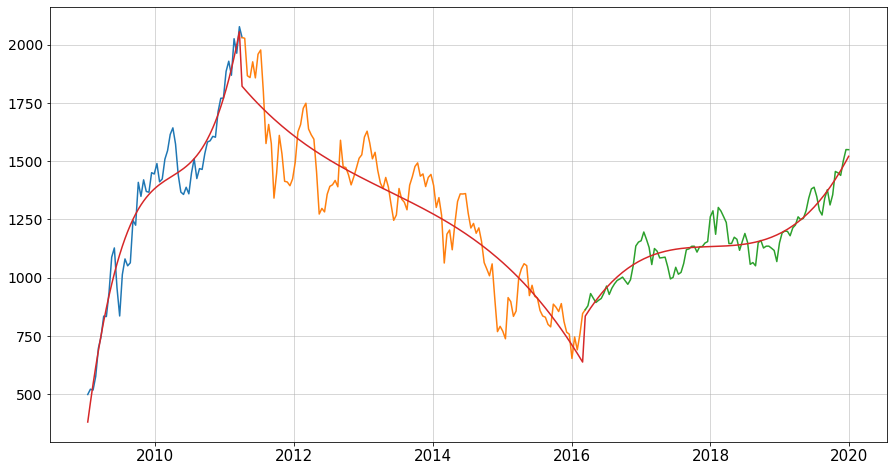

In [46]:
draw(partial_series);
partial_series_trend = (
    partial_series.p1.polynomial_trend(3)
    .append(partial_series.p2.polynomial_trend(3))
    .append(partial_series.p3.polynomial_trend(3))
)
partial_series_trend_remains = (series - partial_series_trend)
draw(partial_series_trend);

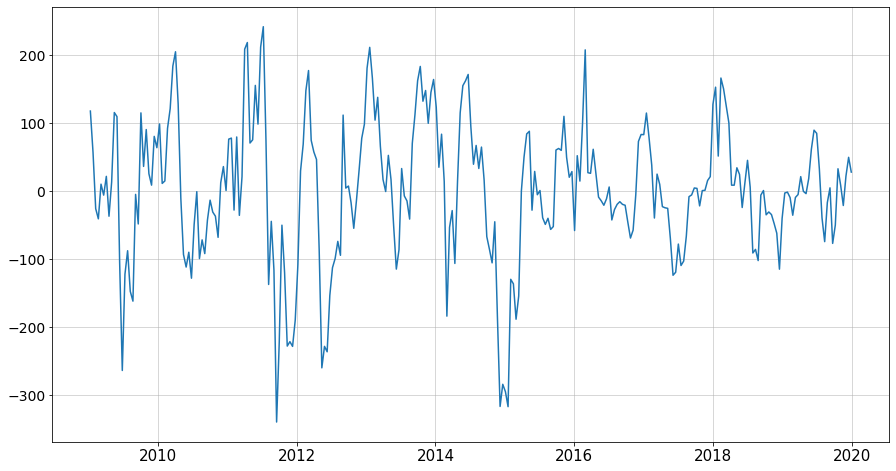

In [47]:
draw(partial_series_trend_remains);

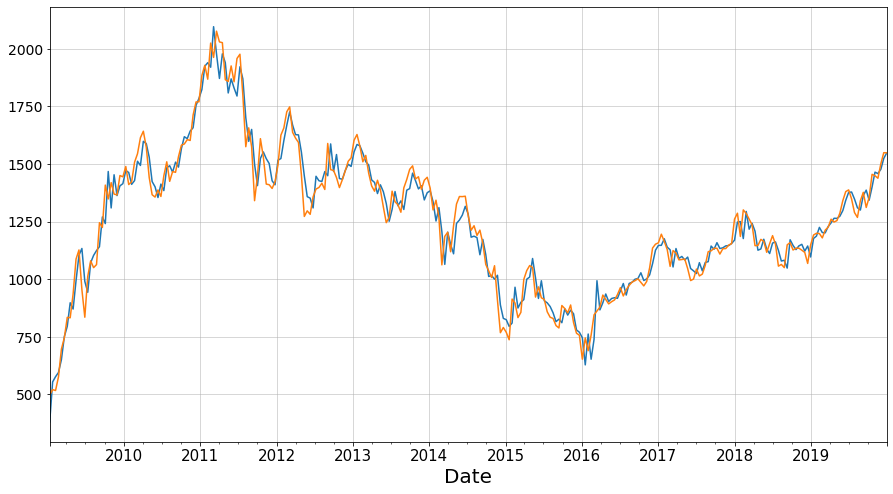

In [48]:
_ = ARIMA(partial_series_trend_remains, order=(5, 0, 4)).fit()
(partial_series_trend + _.fittedvalues).plot()
series.plot();

### Оценивание точности

In [49]:
def mape(other1, other):
    """ Критерий MAPE """
    return np.mean(np.abs((other1 - other) / other1)) * 100

def mae(other1, other):
    """ Критерий MAE """
    return np.mean(np.abs(other1 - other))

In [50]:
print(mape(series, series_trend + arima_by_series_remains.fittedvalues))
mae(series, series_trend + arima_by_series_remains.fittedvalues)

4.042018466846954


48.43602304702988

In [51]:
print(mape(series, series - arima_by_series.resid))
mae(series, series - arima_by_series.resid)

4.257377503294336


51.24219688704404

In [52]:
print(mape(series, (partial_series_trend + _.fittedvalues)))
mae(series, (partial_series_trend + _.fittedvalues))

3.988448801476553


47.024759463474844

# ARX-GARCH модель

In [53]:
week_series = df[('2009-01' < df.index) & (df.index < '2020')].Close
week_series = week_series.resample('11d').last()

ar_by_week_series = ARX(week_series, lags=1)
ar_by_week_series_fitted = ar_by_week_series.fit()
display(ar_by_week_series_fitted.summary())

argarch_by_week_series = ar_by_week_series
argarch_by_week_series.volatility = GARCH(p=1, q=1)
argarch_by_week_series_fitted = argarch_by_week_series.fit()
argarch_by_week_series_fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     AR - Constant Variance Model Results                     
==============================================================================
Dep. Variable:                  Close   R-squared:                       0.956
Mean Model:                        AR   Adj. R-squared:                  0.956
Vol Model:          Constant Variance   Log-Likelihood:               -2019.70
Distribution:                  Normal   AIC:                           4045.40
Method:            Maximum Likelihood   BIC:                           4057.09
                                        No. Observations:                  364
Date:                Thu, Mar 26 2020   Df Residuals:                      361
Time:                        22:59:33   Df Model:                            3
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
Const         38.5468     14.977      2.574  1.006e-02 [  9.193, 67.901]
Close[1]       0.9714  1.234e-02     78.750      0.000 [  0.947,  0.996]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
sigma2      3863.6534    385.085     10.033  1.089e-23 [3.109e+03,4.618e+03]
============================================================================

Covariance estimator: White's Heteroskedasticity Consistent Estimator
"""

Iteration:      1,   Func. Count:      7,   Neg. LLF: 1998.3765611978554
Iteration:      2,   Func. Count:     20,   Neg. LLF: 1998.2771424189123
Iteration:      3,   Func. Count:     28,   Neg. LLF: 1997.8438932938657
Iteration:      4,   Func. Count:     36,   Neg. LLF: 1997.6088159002875
Iteration:      5,   Func. Count:     44,   Neg. LLF: 1997.5194061308632
Iteration:      6,   Func. Count:     52,   Neg. LLF: 1997.4257761550161
Iteration:      7,   Func. Count:     59,   Neg. LLF: 1997.4236849312558
Iteration:      8,   Func. Count:     66,   Neg. LLF: 1997.422961243401
Iteration:      9,   Func. Count:     73,   Neg. LLF: 1997.418867306448
Iteration:     10,   Func. Count:     80,   Neg. LLF: 1997.4013710129866
Iteration:     11,   Func. Count:     87,   Neg. LLF: 1997.3705089454936
Iteration:     12,   Func. Count:     94,   Neg. LLF: 1997.3705019629028
Iteration:     13,   Func. Count:    101,   Neg. LLF: 1997.3704944384485
Iteration:     14,   Func. Count:    108,   Neg. LLF:

<class 'statsmodels.iolib.summary.Summary'>
"""
                           AR - GARCH Model Results                           
==============================================================================
Dep. Variable:                  Close   R-squared:                       0.956
Mean Model:                        AR   Adj. R-squared:                  0.956
Vol Model:                      GARCH   Log-Likelihood:               -1997.36
Distribution:                  Normal   AIC:                           4004.73
Method:            Maximum Likelihood   BIC:                           4024.21
                                        No. Observations:                  364
Date:                Thu, Mar 26 2020   Df Residuals:                      359
Time:                        22:59:33   Df Model:                            5
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
Const         34.1763     16.500      2.071  3.833e-02 [  1.837, 66.515]
Close[1]       0.9735  1.465e-02     66.473      0.000 [  0.945,  1.002]
                              Volatility Model                             
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega         70.9586     70.602      1.005      0.315  [-67.419,2.093e+02]
alpha[1]       0.0635  3.531e-02      1.799  7.206e-02 [-5.692e-03,  0.133]
beta[1]        0.9149  4.642e-02     19.709  1.805e-86    [  0.824,  1.006]
===========================================================================

Covariance estimator: robust
"""

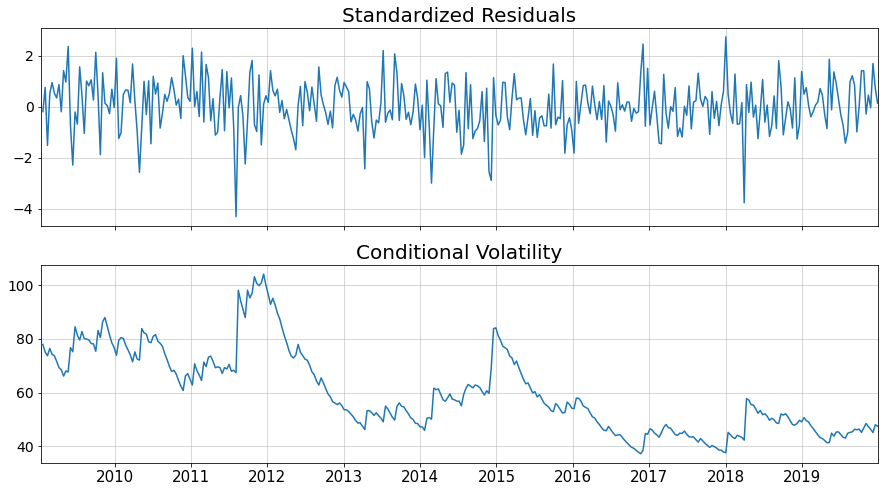

In [54]:
argarch_by_week_series_fitted.plot();

In [55]:
q = argarch_by_week_series_fitted.forecast(horizon=3, method='simulation', simulations=1_000).simulations.values

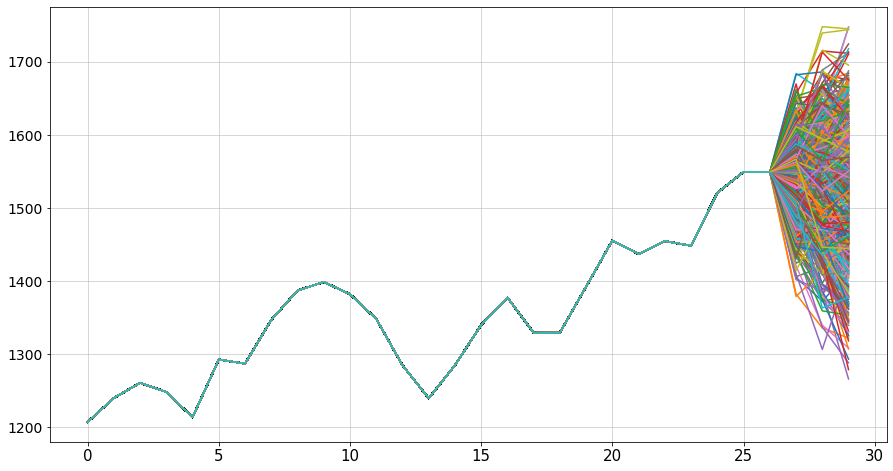

In [56]:
_ = []
for i in q[-1]:
    _.extend(i)
    plt.plot(
        range(len(week_series) + len(i))[:30],
        np.append(week_series.to_list(), _)[-30:]
    )
    _.clear()

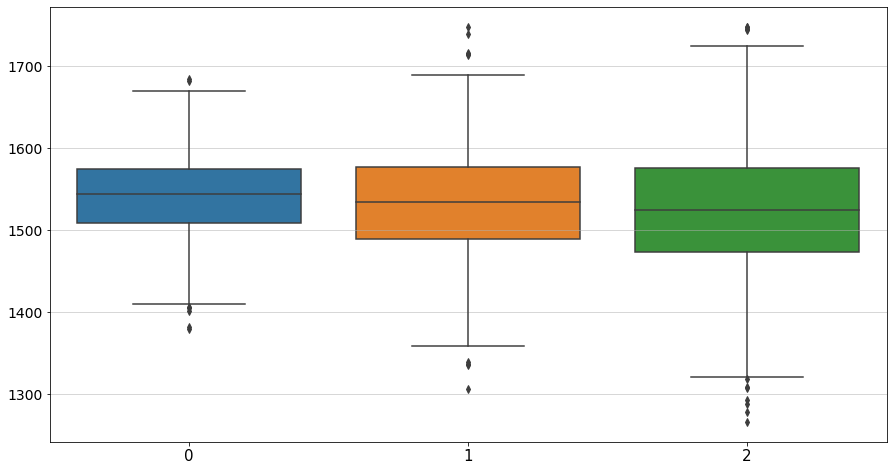

In [57]:
sns.boxplot(data=q[-1]);

# VAR модель

[-2.66359249 -1.70970751]


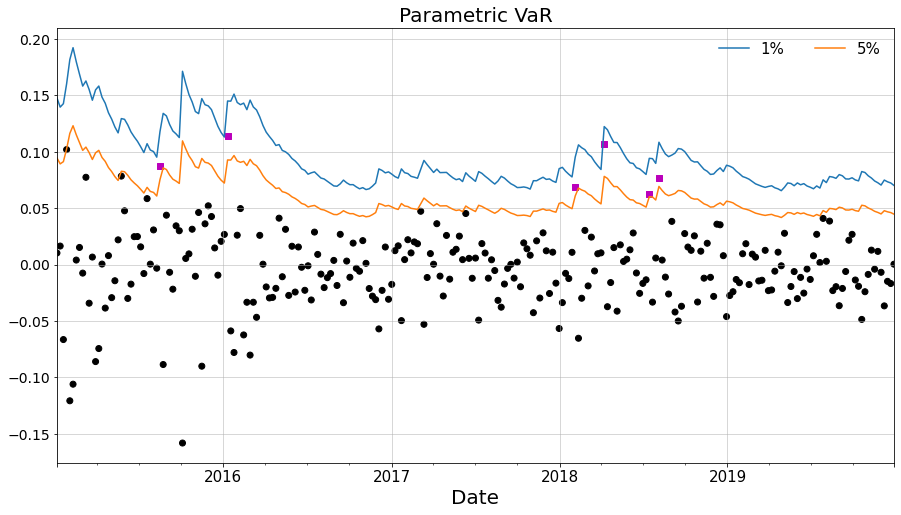

In [58]:
# week_series_changed = arch.data.sp500.load()['Adj Close'].pct_change().dropna() * 100
week_series_changed = df[('2009-01' < df.index) & (df.index < '2020')].Close
week_series_changed = week_series_changed.resample('7d').last()

week_series_changed = week_series_changed.pct_change().dropna()
am = arch_model(week_series_changed, vol='Garch', p=1, o=0, q=1, dist='skewt')
res = am.fit(disp='off', last_obs='2014-12-31')

forecasts = res.forecast(start='2015-1-1')
cond_mean = forecasts.mean['2015':]
cond_var = forecasts.variance['2015':]
q = am.distribution.ppf([0.01, 0.05], res.params[-2:])
print(q)

value_at_risk = -cond_mean.values - np.sqrt(cond_var).values * q[None, :]
value_at_risk = pd.DataFrame(
    value_at_risk, columns=['1%', '5%'], index=cond_var.index)
ax = value_at_risk.plot(legend=False)
xl = ax.set_xlim(value_at_risk.index[0], value_at_risk.index[-1])
rets_2018 = week_series_changed['2015':].copy()
rets_2018.name = 'S&P 500 Return'
c = []
for idx in value_at_risk.index:
    if rets_2018[idx] > -value_at_risk.loc[idx, '5%']:
        c.append('#000000')
    elif rets_2018[idx] < -value_at_risk.loc[idx, '1%']:
        c.append('#BB0000')
    else:
        c.append('#BB00BB')
c = np.array(c, dtype='object')
labels = {
    '#BB0000': '1% Exceedence',
    '#BB00BB': '5% Exceedence',
    '#000000': 'No Exceedence'
}
markers = {'#BB0000': 'x', '#BB00BB': 's', '#000000': 'o'}
for color in np.unique(c):
    sel = c == color
    ax.scatter(
        rets_2018.index[sel],
        -rets_2018.loc[sel],
        marker=markers[color],
        c=c[sel],
    )
ax.set_title('Parametric VaR')
leg = ax.legend(frameon=False, ncol=3)

# Holt-Winters

In [59]:
__1= ExponentialSmoothing(series, seasonal_periods=9, trend='add', seasonal='mul', damped=True).fit()

In [60]:
__1.summary()

Dep. Variable:,endog,No. Observations:,287
Model:,ExponentialSmoothing,SSE,1322775.750
Optimized:,True,AIC,2449.063
Trend:,Additive,BIC,2500.296
Seasonal:,Multiplicative,AICC,2451.078
Seasonal Periods:,9,Date:,"Thu, 26 Mar 2020"
Box-Cox:,False,Time:,22:59:37
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,1.0000000,alpha,True
smoothing_slope,0.0552647,beta,True


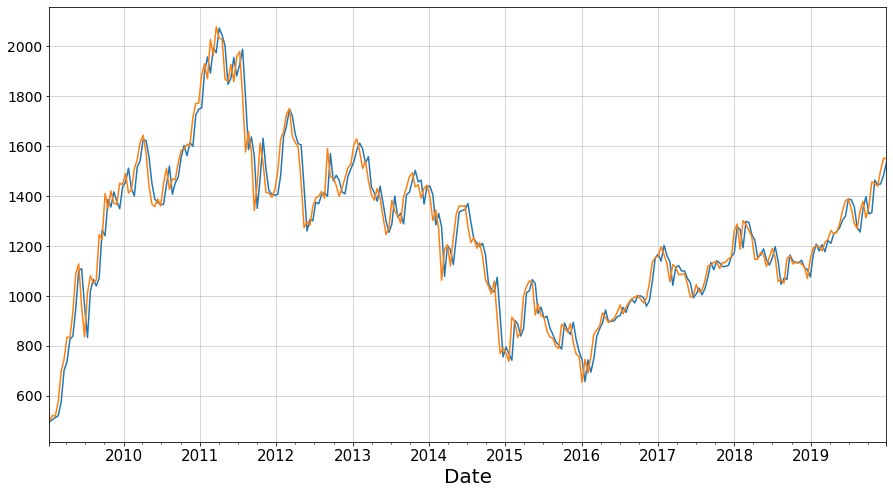

In [61]:
__1.fittedvalues.plot();
series.plot()

In [62]:
Model(series).aic(__1.fittedvalues, 5)

8.47060391763121

In [63]:
print(mae(series, __1.fittedvalues))
mape(series, __1.fittedvalues)

50.52386595246031


4.183947697125693

In [64]:
pprint(df['2020-01-13']['Close'])
pprint(df['2020-01-27']['Close'])
pprint(df['2020-02-10']['Close'])
df['2020-02-25']['Close']

Date
2020-01-13    1619.73
Name: Close, dtype: float64
Date
2020-01-27    1541.9
Name: Close, dtype: float64
Date
2020-02-10    1503.95
Name: Close, dtype: float64


Date
2020-02-25    1446.11
Name: Close, dtype: float64

In [65]:
__1.forecast(4)

2020-01-12    1558.864978
2020-01-26    1580.815649
2020-02-09    1600.238723
2020-02-23    1573.226496
Freq: 14D, dtype: float64